# Approche Bag of Words (BoW)

## Chargement des données

In [6]:
from pathlib import Path
from dataset import load_data_film


DATASET_PATH_TRAIN = Path("data/aclImdb/train")
DATASET_PATH_TEST = Path("data/aclImdb/test")

NB_DOC_MAX = 1000 # par classe
IMDB_CLASSES  = ['neg','pos']
VOC_SIZE = 10000
BATCH_SIZE = 32


txts, files, filelabels = load_data_film(DATASET_PATH_TRAIN, max_size = NB_DOC_MAX)
txts_test, files_test, filelabels_test = load_data_film(DATASET_PATH_TEST, max_size = NB_DOC_MAX)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
vectorizer = CountVectorizer(input='content', encoding='utf-8',
                             decode_error='strict', strip_accents=None, 
                             lowercase=True, preprocessor=None, tokenizer=None, 
                             stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', 
                             ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, 
                             max_features=None, vocabulary=None, binary=False)

X = vectorizer.fit_transform(txts)

In [9]:
vectorizer.get_feature_names_out()[2300:2350]

array(['bonded', 'bonding', 'bonds', 'bone', 'bonejack', 'bones', 'bonet',
       'bonfire', 'bonfires', 'bonham', 'bonjour', 'bonkers', 'bonnie',
       'bonny', 'bono', 'bonus', 'bony', 'bonzai', 'boo', 'boobless',
       'boobs', 'booby', 'boogey', 'boogeyman', 'boogie', 'book',
       'booked', 'bookends', 'booking', 'booklet', 'books', 'bookstore',
       'boom', 'boomerang', 'boon', 'boonies', 'booooring', 'boorish',
       'boorman', 'boost', 'boot', 'booth', 'bootleg', 'boots', 'boozy',
       'bopper', 'border', 'bordering', 'borderline', 'borderlines'],
      dtype=object)

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, filelabels)


#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
lr_clf.fit(X, filelabels)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X, filelabels)


true = filelabels_test
test_corpus = txts_test
X_test = vectorizer.transform(test_corpus)

pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)


print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")

/home/lauronta/Bureau/IODAA/iodaa/SDA_APA/tuto_deep/notebooks/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naïve Bayes accuracy: 0.7975
Logistic Regression accuracy: 0.8015
SVM accuracy: 0.785


# Recherche des meilleurs pré-traitements

## GridSearch

Le but de la première étape est de regarder les performances que l'on peut obtenir en faisant varier les paramètres sur une plage importante de paramètres. 

## StopWords

On the importance of a good stopwords list (https://aclanthology.org/W18-2502/)

In [11]:
# will try default/ nltk

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir='.')
nltk.data.path.append('.')

stop_words_nltk = stopwords.words('english')


[nltk_data] Downloading package stopwords to ....
[nltk_data]   Package stopwords is already up-to-date!


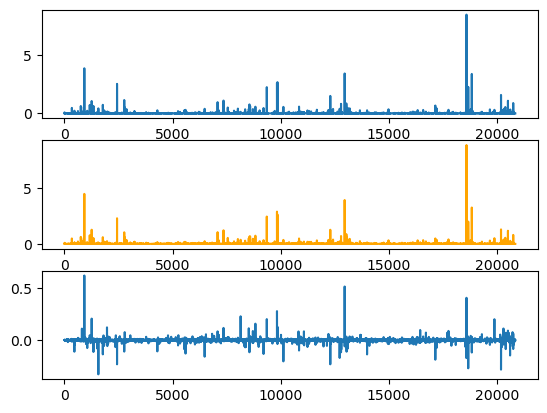

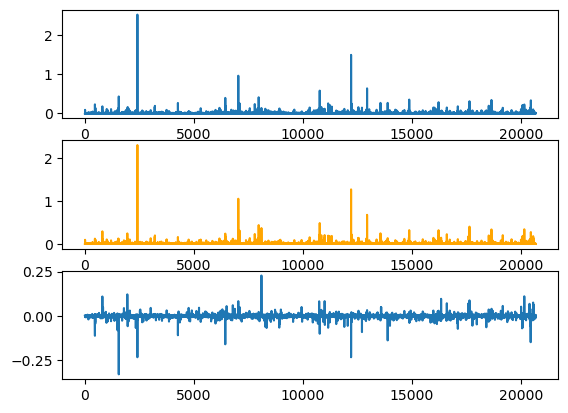

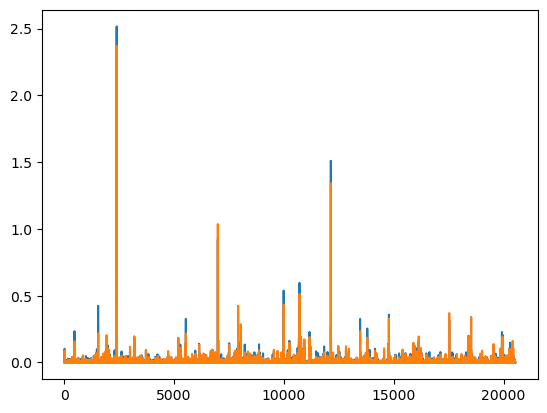

In [62]:
# faire un plot avec les fréquences des words

import matplotlib.pyplot as plt


## sans stopwords
vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(txts)


ids_to_word = {val:key for key,val in vectorizer.vocabulary_.items()}
freq_pos = tf[:1000].mean(axis=0)
freq_neg = tf[1001:].mean(axis=0)

fig, ax = plt.subplots(3,1)
ax[0].plot(freq_pos.tolist()[0])
ax[1].plot(freq_neg.tolist()[0],  color = 'orange')
ax[2].plot((freq_neg-freq_pos).tolist()[0])
#plt.xticks(list(ids_to_word.keys()), list(ids_to_word.values()))
plt.show()


### With stop words (nltk)
vectorizer = CountVectorizer(stop_words=stop_words_nltk)
tf = vectorizer.fit_transform(txts)
freq_pos = tf[:1000].mean(axis=0)
freq_neg = tf[1001:].mean(axis=0)


fig, ax = plt.subplots(3,1)
ax[0].plot(freq_pos.tolist()[0])
ax[1].plot(freq_neg.tolist()[0],  color = 'orange')
ax[2].plot((freq_neg-freq_pos).tolist()[0])
plt.show()

#print(len(vectorizer.vocabulary_))
#print(tf.sum(axis=0).tolist()[0])


#plt.boxplot(tf.sum(axis=0).tolist()[0])


### With stop words (default)
vectorizer = CountVectorizer(stop_words='english')
tf = vectorizer.fit_transform(txts)
plt.plot([i for i in range(tf[:500].shape[1])], tf[:500].mean(axis=0).tolist()[0])
plt.plot([i for i in range(tf[501:].shape[1])], tf[501:].mean(axis=0).tolist()[0])


## max_features

La taille du vocabulaire a-t-elle une influence sur la performance que l'on obtient en sortie de notre modèle ?
On regarde le comportement face à une variation de la taille du voc.

In [13]:
import numpy as np
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from time import time

max_feature_grid = np.geomspace(100, 20000, 50, dtype=int)
score = []
times = []
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(txts, filelabels, random_state=42)


for i in tqdm(max_feature_grid) :
    t1 = time()
    vectorizer = CountVectorizer(max_features=i)
    X_train_vect = vectorizer.fit_transform(X_train)
    X_val_vect = vectorizer.transform(X_val)
    t2 = time()

    clf = LinearSVC()
    clf.fit(X_train_vect, y_train)
    
    y_pred = clf.predict(X_val_vect)
    

    score.append(accuracy_score(y_val, y_pred))
    times.append(t2-t1)



  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Δscore  : 0.064
Relative in score : 8.36 %


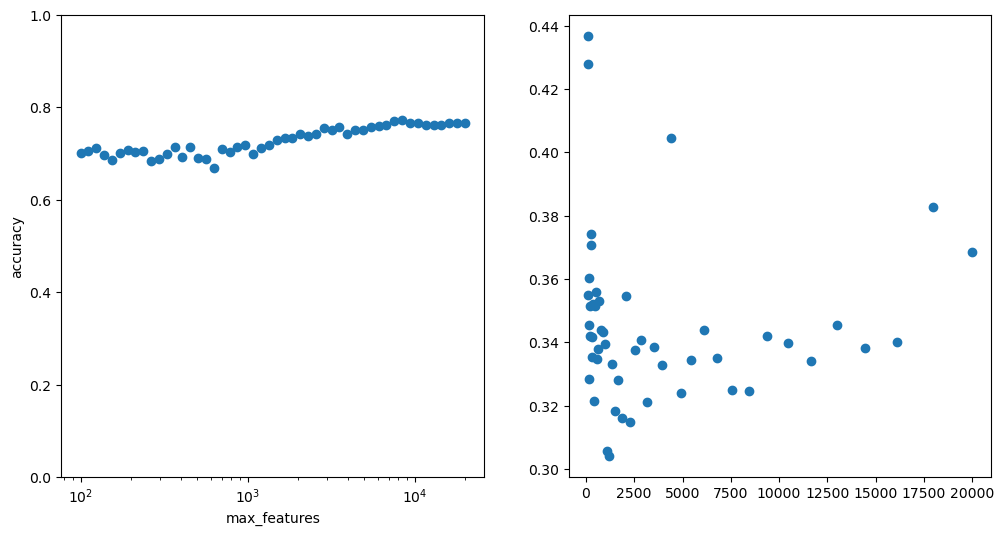

In [14]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].plot(max_feature_grid, score, marker='o', ls='')
ax[0].set_xlabel('max_features')
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0,1)
ax[0].set_xscale('log')

print(f"Δscore  : {score[-1] - score[0]:.3f}")
print(f"Relative in score : {(score[-1] - score[0])/score[-1]*100:.2f} %")
ax[1].plot(max_feature_grid, times, marker='o', ls='')
#fig.savefig('test')
plt.show()

## Optuna

In [64]:
import optuna

# import des modèles necessaires
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Define an objective function to be minimized.
def objective(trial):

    # choice of classifier
    clf_name = trial.suggest_categorical('classifier', ['LinearSVC', 'RandomForestClassifier',
                                                        'KNeighborsClassifier','MultinomialNB','LogisticRegression',
                                                        'MLPClassifier', 'DecisionTreeClassifier'])
    
    # preprocess settings
    stp_wd = trial.suggest_categorical('stop_words', [None, 'english', stop_words_nltk])


    if clf_name == 'LinearSVC':
        svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        clf = LinearSVC(C = svc_c)

    elif clf_name == 'RandomForestClassifier':
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        clf = RandomForestClassifier()
        regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth)

    elif clf_name == 'KNeighborsClassifier':
        clf = KNeighborsClassifier()

    elif clf_name == 'MultinomialNB':
        clf = MultinomialNB()

    elif clf_name == 'LogisticRegression':
        clf = LogisticRegression()

    elif clf_name == 'MLPClassifier':
        clf = MLPClassifier()

    elif clf_name == 'DecisionTreeClassifier':
        clf = DecisionTreeClassifier()

    vectorizer = CountVectorizer(input='content', encoding='utf-8',
                             decode_error='strict', strip_accents=None, 
                             lowercase=True, preprocessor=None, tokenizer=None, 
                             stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', 
                             ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, 
                             max_features=None, vocabulary=None, binary=False)


    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(txts, filelabels, random_state=42)

    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)


    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    acc = accuracy_score(y_val, y_pred)

    return acc

study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(objective, n_trials=50)  # Invoke optimization of the objective function.


[I 2025-02-16 17:43:56,877] A new study created in memory with name: no-name-1cdb17ba-21d8-42da-9c19-3adc9c105792
/home/lauronta/Bureau/IODAA/iodaa/SDA_APA/tuto_deep/notebooks/.conda/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about'

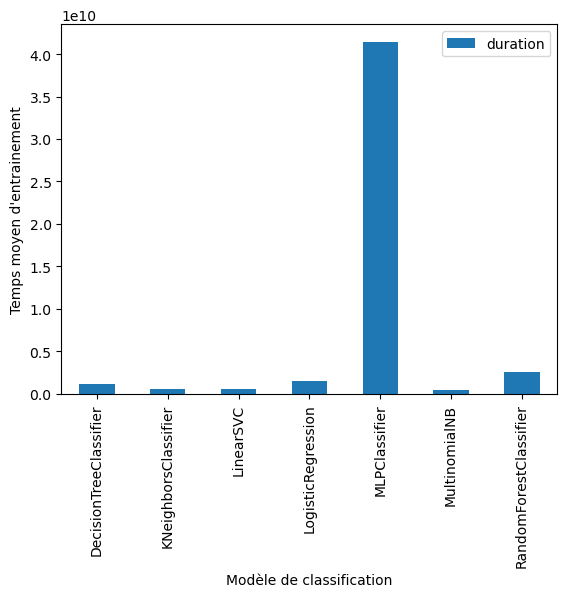

In [65]:
df = study.trials_dataframe()
fig, ax = plt.subplots()
ax = df[['duration', 'params_classifier']].groupby(['params_classifier']).mean().plot(kind='bar', ax = ax)
ax.set_xlabel("Modèle de classification")
ax.set_ylabel("Temps moyen d'entrainement")
plt.show()

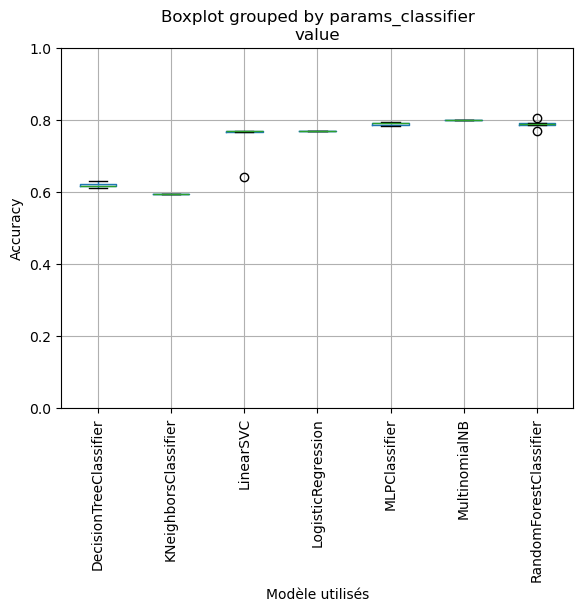

In [66]:
fig, ax = plt.subplots()
ax = df[['value', 'params_classifier']].boxplot(by='params_classifier', rot=90,ax = ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Modèle utilisés")
ax.set_ylim(0,1)
plt.show()

